### Library and Data Processing

To view dashboard visit: https://public.tableau.com/app/profile/leo.li2227/viz/E-commerceSalesDashboard_17231509371580/Overview

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [47]:
data = pd.read_excel('Sales Data.xlsx')
# Get dates for forecast
data['Date'] = data['Year'].astype(str) + '-' + data['Month'].astype(str)
data['Date'] = pd.to_datetime(data['Date'])
# Total revenue by month
df = data.groupby('Date')['Ordered Revenue'].sum().reset_index().rename(columns={'Ordered Revenue':'Monthly Revenue'})

In [52]:
data.sample()

,Year,Month,Subcategory,Category,Model / Style Number,Ordered Revenue,Ordered Revenue - % of Total,Ordered Revenue - Prior Period,Ordered Units,Subcategory (Sales Rank),Glance Views,Change in Glance View - MOM,Change in GV YOY,Conversion Rate,LFO (Price),Date
9742,2021,11,Subcategory 038,Category 13,F3U13306INCH,0.0,0.0,-,0,1040.0,0.0,—,-1,NaN,NaN,2021-11-01


In [53]:
data.groupby(['Date','Category'])['Ordered Revenue'].sum().reset_index().rename(columns={'Ordered Revenue':'Monthly Revenue'})

,Date,Category,Monthly Revenue
0,2021-01-01,Category 01,0.000000e+00
1,2021-01-01,Category 02,5.372027e+03
2,2021-01-01,Category 03,1.014791e+03
3,2021-01-01,Category 05,2.397808e+06
4,2021-01-01,Category 06,3.934972e+01
...,...,...,...
444,2022-06-01,Category 23,2.637233e+05
445,2022-06-01,Category 24,2.176657e+06
446,2022-06-01,Category 25,2.239411e+05
447,2022-06-01,Category 26,1.168172e+03


### SARIMA Forecast

The data shows strong seasonality with peak at November during Black Friday. Holt's Winters could be a great model for this; however, there are only 18 monhts of data which is less than 2 cycles. Therefore, we will use SARIMAX model that considers seasonality to forecast

#### Parameter tuning

In [98]:
# Determine non-seasonal differencing component
from pmdarima.arima.utils import ndiffs
ndiffs(df['Monthly Revenue'])

0

We will set d = 0 in the model

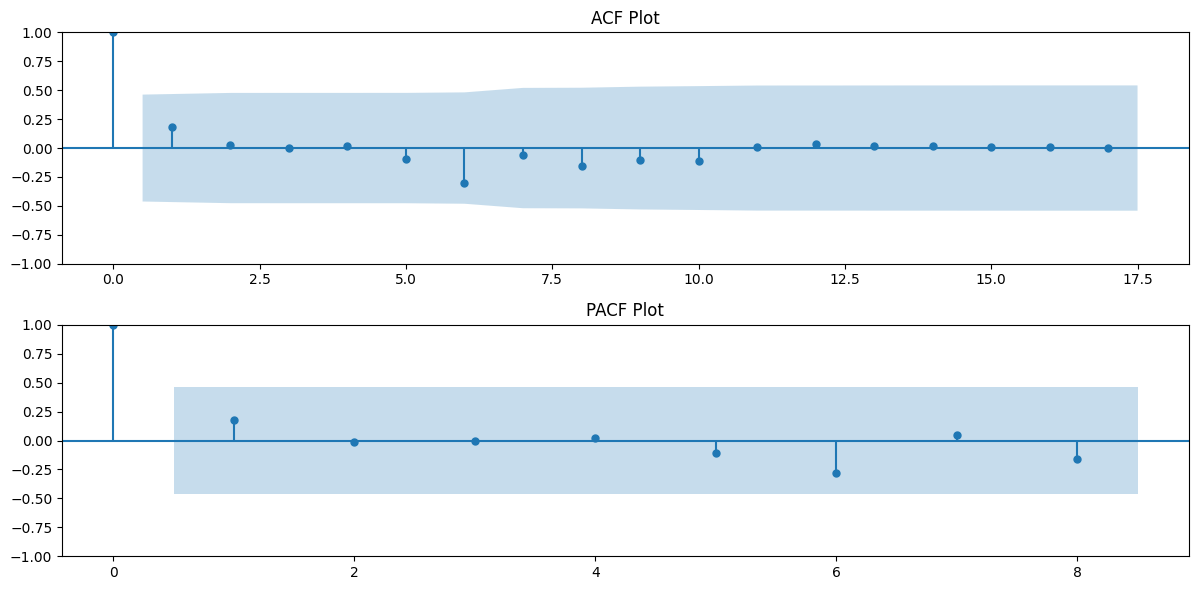

In [88]:
# Plot ACF to help select moving average and PACF to help select autoregressive
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df['Monthly Revenue'], lags=17, ax=plt.gca())
plt.title('ACF Plot')
plt.subplot(212)
plot_pacf(df['Monthly Revenue'], lags=8, ax=plt.gca())
plt.title('PACF Plot')
plt.tight_layout()
plt.show()

No strong indication in ACF and PACF, will use cross validation to select p and q 
Since we only have 1 full period of data so will set P and Q = 1 for seasonal component of the model

In [2]:
# 4 fold cross validation to select p and q
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Prepare TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)
p_values = list(range(9))
q_values = list(range(9))

model_tuning = []
for p in p_values:
    for q in q_values:
        mse_values = []
        for train_index, test_index in tscv.split(df):
            train, test = df.iloc[train_index], df.iloc[test_index]
            try:
                model = SARIMAX(train['Monthly Revenue'], order=(p, 0, q), seasonal_order=(1, 0, 1, 12)).fit()
                forecast = model.forecast(steps=len(test))
                mse_values.append(mean_squared_error(test['Monthly Revenue'], forecast))    
            except Exception as e:
                mse_values.append(np.nan)
        model_tuning.append({'p': p,'q': q,'MSE': np.nanmean(mse_values)})
        
model_tuning = pd.DataFrame(model_tuning)

In [176]:
# Will use this for the final model
model_tuning[model_tuning['MSE']==model_tuning['MSE'].min()]

,p,q,MSE
64,7,1,1.176675e+12


#### Model Evaluation

Now we have the best parameter, will train it on the first 15 months of data and predict the next 3 months for forecast error, fit, and accuracy 

In [203]:
train = df.iloc[:15]
test = df.iloc[15:]

In [207]:
best_model = SARIMAX(train['Monthly Revenue'], order=(7, 0, 1), seasonal_order=(1, 0, 1, 12)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52588D+01    |proj g|=  6.44785D+01

At iterate    5    f=  1.62122D+01    |proj g|=  1.08317D-01

At iterate   10    f=  1.61743D+01    |proj g|=  1.06971D-01

At iterate   15    f=  1.61036D+01    |proj g|=  5.32540D-02

At iterate   20    f=  1.60942D+01    |proj g|=  1.71841D-02


 This problem is unconstrained.



At iterate   25    f=  1.60829D+01    |proj g|=  3.93547D-02

At iterate   30    f=  1.60752D+01    |proj g|=  2.25266D-02

At iterate   35    f=  1.60713D+01    |proj g|=  1.48496D-02

At iterate   40    f=  1.60706D+01    |proj g|=  2.58329D-03

At iterate   45    f=  1.60706D+01    |proj g|=  3.08336D-04

At iterate   50    f=  1.60706D+01    |proj g|=  5.39309D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   5.393D-05   1.607D+01
  F =   16.070619225831376     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


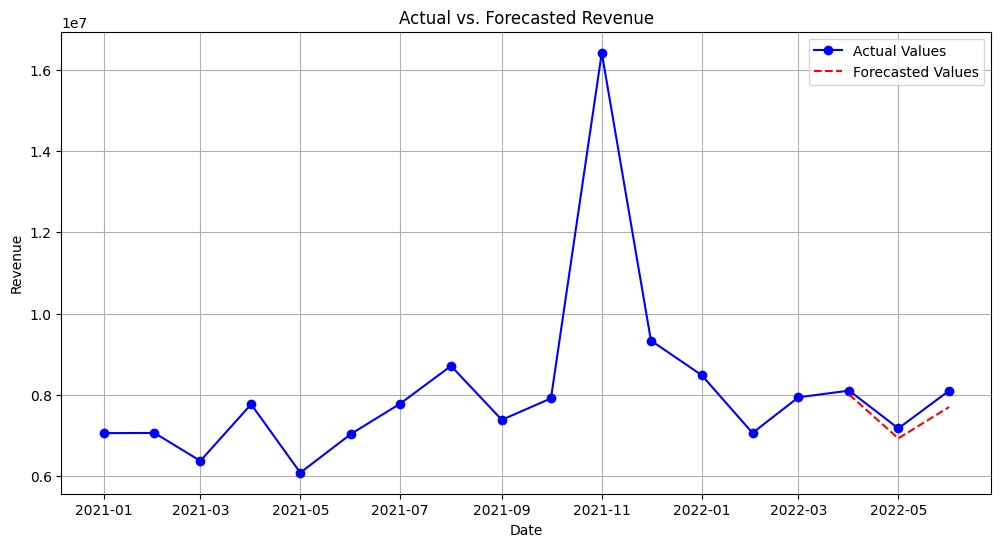

In [208]:
# Forecast for the training set
forecast = best_model.forecast(steps=len(test))
forecast_index = test.index

# Data with actual vs forecast for plotting
results = pd.DataFrame({
    'Date': df['Date'],
    'Actual': pd.concat([train['Monthly Revenue'], test['Monthly Revenue']]),
    'Forecast': pd.concat([pd.Series([np.nan] * len(train), index=train.index), pd.Series(forecast, index=forecast_index)])
})

plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Actual'], label='Actual Values', color='blue', marker='o')
plt.plot(results['Date'], results['Forecast'], label='Forecasted Values', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs. Forecasted Revenue')
plt.legend()
plt.grid(True)
plt.show()

The graph shows that the model fits extremely well for the next 3 months: a great sign

In [213]:
# Get the mean squared error for our model
mean_squared_error(test['Monthly Revenue'],forecast)

77238958543.0994

In [212]:
# A percentage point to check for accuracy
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(test['Monthly Revenue'],forecast)

0.031964098453230005

Our model with only 15 months of data shows high level of accuracy. Since it works so well, we can keep this one as the final model

#### Forecasting

In [234]:
# Note historical vs predicted for dashboard
df['Note'] = 'Historical'

forecasted = pd.DataFrame({'Date':pd.date_range(start='2022-07-01', end='2023-06-30', freq='MS'),
              'Monthly Revenue':best_model.forecast(steps=15)[3:],
              'Note': 'Forcasted'})

final = pd.concat([df,forecasted])
final.to_csv('forcasted.csv',index=False)

### YOY Product Analysis

Since we have 18 months of data, we can compare 2021 Jan - June vs 2022 Jan - June in terms of revenue and conversion to see which models have the biggest improvement 

In [324]:
data['Conversion'] = data['Conversion Rate'] * data['Glance Views']
data2021 = data[data['Date']<= '2021-06-01']
data2022 = data[data['Date']>= '2022-01-01']

In [311]:
data2021 = data2021.groupby('Model / Style Number')[['Ordered Revenue','Glance Views','Conversion']].sum().reset_index().rename(
    columns = {'Ordered Revenue':'2021 Revenue'})
data2021['2021 CVR'] = data2021['Conversion']/data2021['Glance Views']
data2021 = data2021.drop(columns = ['Conversion','Glance Views'])

data2022 = data2022.groupby('Model / Style Number')[['Ordered Revenue','Glance Views','Conversion']].sum().reset_index().rename(
    columns = {'Ordered Revenue':'2022 Revenue'})
data2022['2022 CVR'] = data2022['Conversion']/data2022['Glance Views']
data2022 = data2022.drop(columns = ['Conversion','Glance Views'])

In [312]:
yoy = pd.merge(data2021,data2022,on = 'Model / Style Number',how = 'inner')

In [313]:
yoy['Reveneu Change'] = (yoy['2022 Revenue'] - yoy['2021 Revenue'])/yoy['2021 Revenue']
yoy['CVR Change'] = (yoy['2022 CVR'] - yoy['2021 CVR'])/yoy['2021 CVR']

In [315]:
yoy.dropna().to_csv('yoy.csv',index = False)